![](https://houseclever.ru/netcat_files/images/1575471993_istock.webp)

In [1]:
import numpy as np 
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

pd.set_option('display.max_columns', None)

In [2]:
stroke = pd.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

# Basic information

In [3]:
stroke.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [4]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are 201 missing values in bmi

Correlation between features

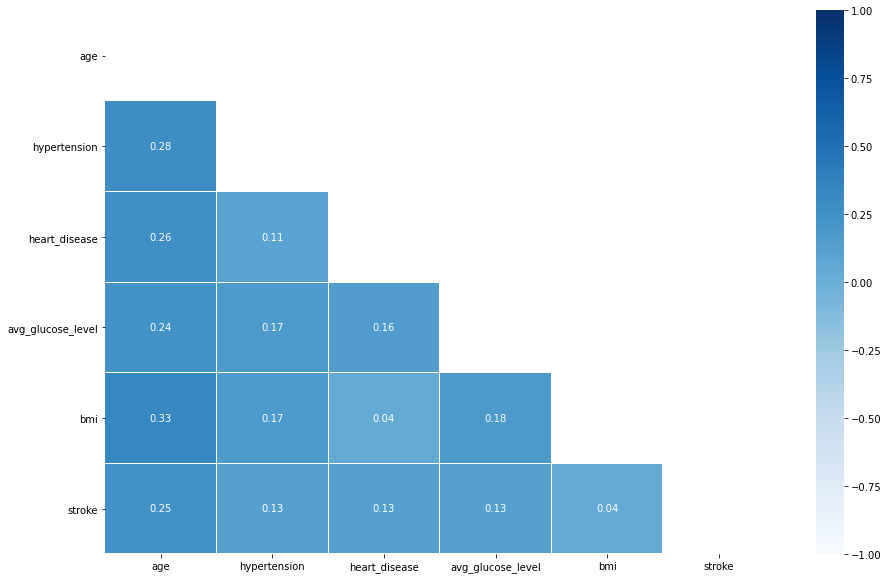

In [5]:
stroke_i = stroke.drop('id', axis = 1)
matrix = np.triu(stroke_i.corr())
plt.figure(figsize=(15, 10))
sns.heatmap(stroke_i.corr(), annot = True, cmap = 'Blues', fmt=".2f", mask = matrix, vmin = -1, vmax = 1, linewidths = 0.1, linecolor = 'white')
plt.show()

# EDA

**Distribution of stroke by gender**

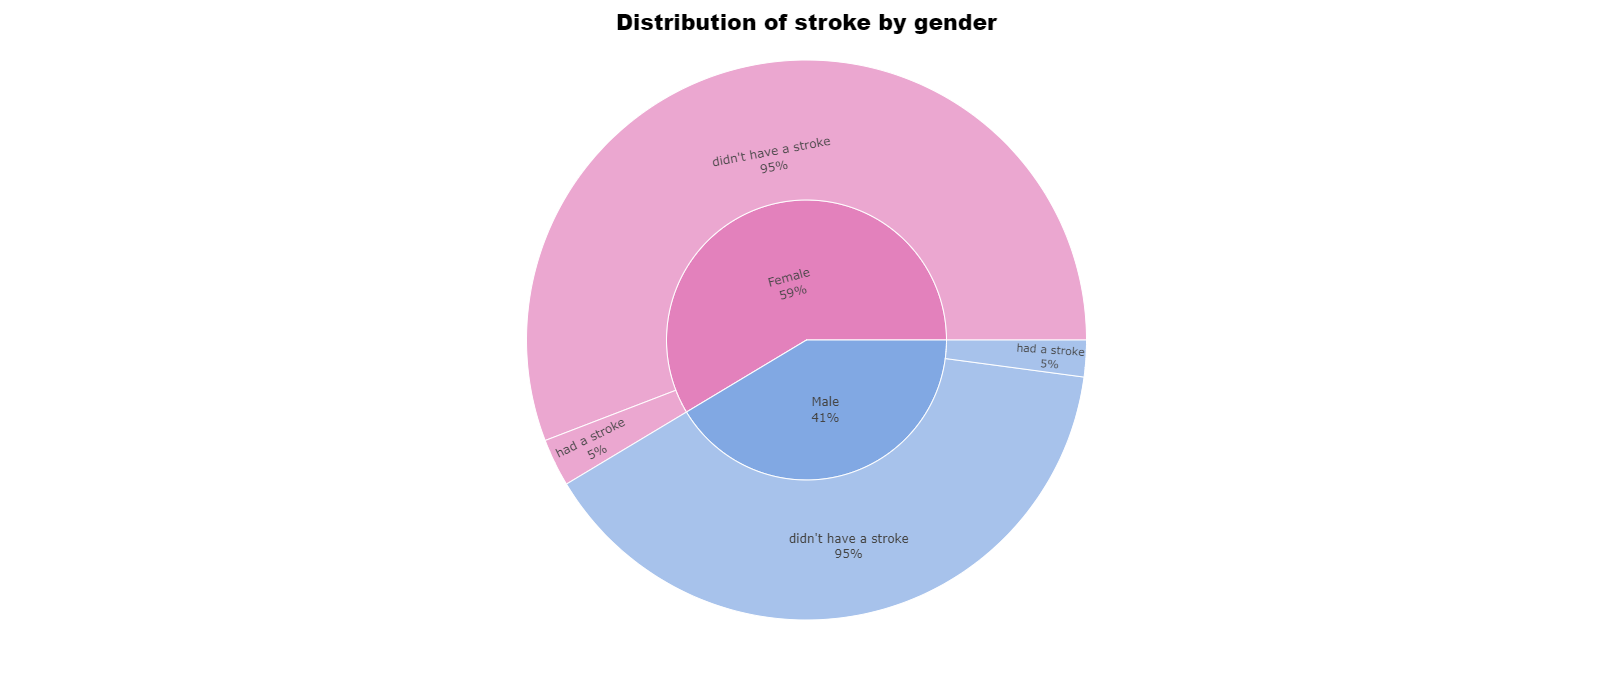

In [13]:
dst_st_gen = stroke.query('gender != "Other"').groupby(['gender', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
dst_st_gen.iloc[[0, 2], 1] = "didn't have a stroke"
dst_st_gen.iloc[[1, 3], 1] = "had a stroke"

fig = px.sunburst(dst_st_gen, path = ['gender', 'stroke'], values = 'count', color = 'gender',
                 color_discrete_map = {'Female': '#e381bc', 'Male': '#81a8e3'}, width = 700, height = 700)

fig.update_layout(annotations = [dict(text = 'Distribution of stroke by gender', 
                                      x = 0.5, y = 1.1, font_size = 22, showarrow = False, 
                                      font_family = 'Arial Black',
                                      font_color = 'black')])

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

**Affect of age group, hypertension, heart diseases, living conditions, group of bmi, group of glucose level and smoking status on risk of stroke**

For body mass index classify I used information from [American cancer society](https://www.cancer.org/cancer/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html). For classificaton by average glucose level I used information from [GLOBAL DIABETES COMMUNITY](https://www.diabetes.co.uk/diabetes_care/blood-sugar-level-ranges.html).

In [18]:
# Create age groups
stroke['age_group'] = 0
for i in range(len(stroke.index)):
    if stroke.iloc[i, 2] < 2:
        stroke.iloc[i, 12] = 'baby'
    elif stroke.iloc[i, 2] < 17 and stroke.iloc[i, 2] >= 2:
        stroke.iloc[i, 12] = 'child'
    elif stroke.iloc[i, 2] < 30 and stroke.iloc[i, 2] >= 17:
        stroke.iloc[i, 12] = 'young adults'
    elif stroke.iloc[i, 2] < 60 and stroke.iloc[i, 2] >= 30:
        stroke.iloc[i, 12] = 'middle-aged adults'
    elif stroke.iloc[i, 2] < 80 and stroke.iloc[i, 2] >= 60:
        stroke.iloc[i, 12] = 'old-aged adults'
    else:
        stroke.iloc[i, 12] = 'long-lived'
        
# Imputing missing values in bmi
mean_bmi = stroke.groupby(['gender', 'age_group']).agg({'bmi': 'mean'}).reset_index()
for i in range(len(stroke.index)):
    if pd.isna(stroke.iloc[i, 9]) == True:
        for j in range(len(mean_bmi.index)):
            if mean_bmi.iloc[j, 0] == stroke.iloc[i, 1] and mean_bmi.iloc[j, 1] == stroke.iloc[i, 12]:
                stroke.iloc[i, 9] = mean_bmi.iloc[j, 2]

# Create bmi groups
stroke['bmi_group'] = 0
for i in range(len(stroke.index)):
    if stroke.iloc[i, 9] < 18.5:
        stroke.iloc[i, 13] = 'Underweight'
    elif stroke.iloc[i, 9] < 25.0 and stroke.iloc[i, 9] >= 18.5:
        stroke.iloc[i, 13] = 'Normal weight'
    elif stroke.iloc[i, 9] < 30.0 and stroke.iloc[i, 9] >= 25.0:
        stroke.iloc[i, 13] = 'Overweight'
    else:
        stroke.iloc[i, 13] = 'Obese'
        
# Create glucose groups
stroke['glucose_group'] = 0
for i in range(len(stroke.index)):
    if stroke.iloc[i, 8] < 100:
        stroke.iloc[i, 14] = 'Normal'
    elif stroke.iloc[i, 8] >= 100 and stroke.iloc[i, 8] < 125:
        stroke.iloc[i, 14] = 'Prediabetes'
    else:
        stroke.iloc[i, 14] = 'Diabetes'

In [83]:
# Grouping by categorical features
dst_st_age = stroke.groupby(['age_group', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
hyper = stroke.groupby(['hypertension', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
heart = stroke.groupby(['heart_disease', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
marry = stroke.groupby(['ever_married', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
work = stroke.groupby(['work_type', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
residence = stroke.groupby(['Residence_type', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
glucose_group = stroke.groupby(['glucose_group', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
bmi_group = stroke.groupby(['bmi_group', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
smoking = stroke.query('smoking_status != "Unknown"').groupby(['smoking_status', 'stroke']).agg({'stroke': 'count'})\
.rename(columns = {'stroke': 'count'}).reset_index()

# Create percent column for data frames
def percent(data):
    data['percent'] = 0
    for i in range(len(data.index)):
        if i < len(data.index)-1:
            if data.iloc[i, 0] == data.iloc[i+1, 0]:
                data.iloc[i, 3] = round((data.iloc[i, 2] / (data.iloc[i, 2] + data.iloc[i+1, 2])) * 100, 1)
            elif data.iloc[i, 0] == data.iloc[i-1, 0]:
                data.iloc[i, 3] = 100 - data.iloc[i-1, 3]
            else:
                data.iloc[i, 3] = 100.0
        else:
            if data.iloc[i, 0] == data.iloc[i-1, 0]:
                data.iloc[i, 3] = 100 - data.iloc[i-1, 3]
            else:
                data.iloc[i, 3] = 100.0
            
percent(dst_st_age)
percent(hyper)
percent(heart)
percent(marry)
percent(work)
percent(residence)
percent(glucose_group)
percent(bmi_group)
percent(smoking)

dst_st_age.iloc[[0,2,4,6,8,10], 1] = "Didn't have a stroke"
dst_st_age.iloc[[1,3,5,7,9], 1] = "Had a stroke"

hyper.iloc[[0,1], 0] = 'No hypertension'
hyper.iloc[[2,3], 0] = 'Hypertension'

heart.iloc[[0,1], 0] = 'No heart diseases'
heart.iloc[[2,3], 0] = 'Heart diseases'

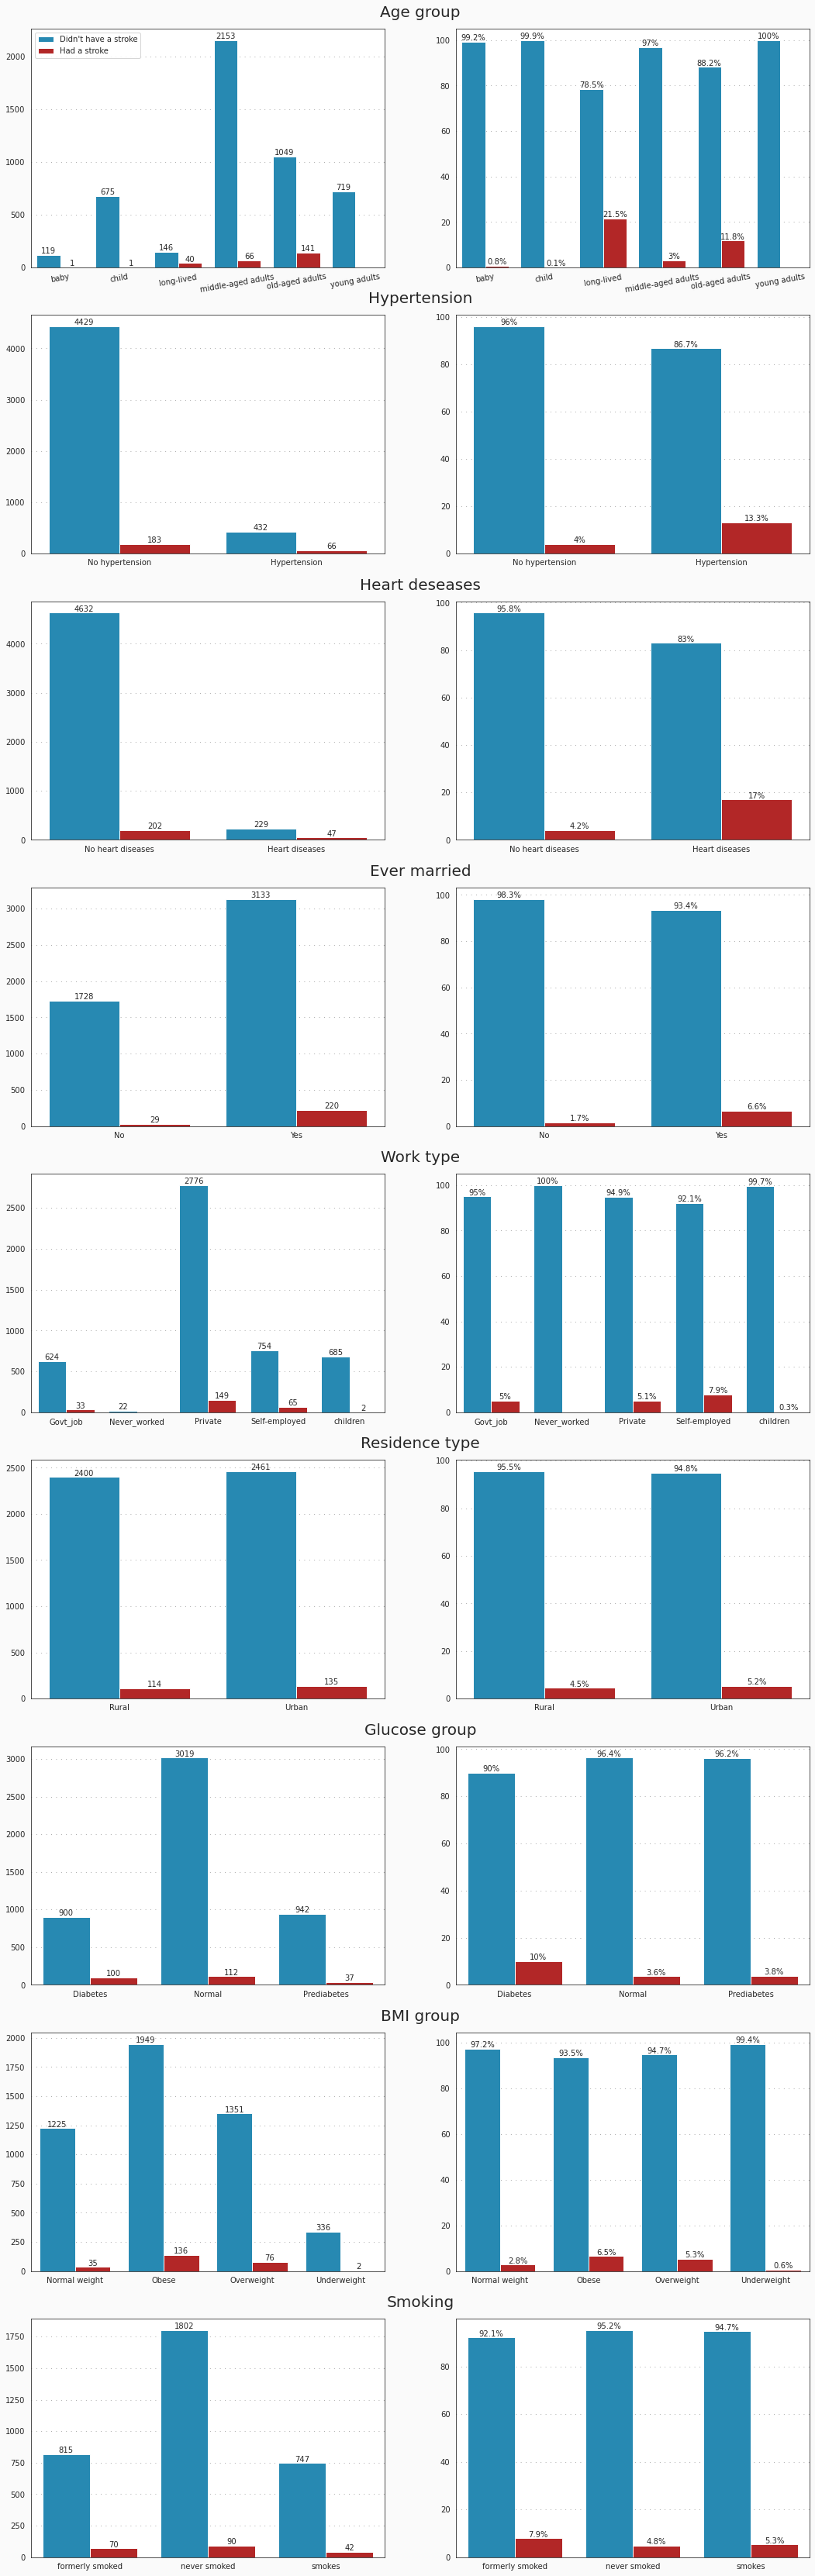

In [108]:
fig = plt.figure(figsize = (18, 60))
fig.patch.set_facecolor('#fafafa')

plt.subplot(921)
sns.set_style('white')
plt.title('Age group', size = 20, x = 1.1, y = 1.03)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
a = sns.barplot(data = dst_st_age, x = dst_st_age['age_group'], y = dst_st_age['count'], hue = dst_st_age['stroke'], palette = ['#1092c9','#c91010'])
plt.xticks(rotation = 10)
plt.ylabel('')
plt.xlabel('')
plt.legend(loc = 'upper left')

plt.subplot(922)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
a2 = sns.barplot(data = dst_st_age, x = dst_st_age['age_group'], y = dst_st_age['percent'], hue = dst_st_age['stroke'], palette = ['#1092c9','#c91010'])
plt.xticks(rotation = 10)
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(923)
sns.set_style('white')
plt.title('Hypertension', size = 20, x = 1.1, y = 1.03)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
b = sns.barplot(data = hyper, x = hyper['hypertension'], y = hyper['count'], hue = hyper['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(924)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
b2 = sns.barplot(data = hyper, x = hyper['hypertension'], y = hyper['percent'], hue = hyper['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(925)
sns.set_style('white')
plt.title('Heart deseases', size = 20, x = 1.1, y = 1.03)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
c = sns.barplot(data = heart, x = heart['heart_disease'], y = heart['count'], hue = heart['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(926)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
c2 = sns.barplot(data = heart, x = heart['heart_disease'], y = heart['percent'], hue = heart['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(927)
sns.set_style('white')
plt.title('Ever married', size = 20, x = 1.1, y = 1.03)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
d = sns.barplot(data = marry, x = marry['ever_married'], y = marry['count'], hue = marry['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(928)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
d2 = sns.barplot(data = marry, x = marry['ever_married'], y = marry['percent'], hue = marry['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(929)
sns.set_style('white')
plt.title('Work type', size = 20, x = 1.1, y = 1.03)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
e = sns.barplot(data = work, x = work['work_type'], y = work['count'], hue = work['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(9,2,10)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
e2 = sns.barplot(data = work, x = work['work_type'], y = work['percent'], hue = work['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(9,2,11)
sns.set_style('white')
plt.title('Residence type', size = 20, x = 1.1, y = 1.03)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
f = sns.barplot(data = residence, x = residence['Residence_type'], y = residence['count'], hue = residence['stroke'], palette = ['#1092c9','#c91010'])

plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)
plt.subplot(9,2,12)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
f2 = sns.barplot(data = residence, x = residence['Residence_type'], y = residence['percent'], hue = residence['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(9,2,13)
sns.set_style('white')
plt.title('Glucose group', size = 20, x = 1.1, y = 1.03)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
g = sns.barplot(data = glucose_group, x = glucose_group['glucose_group'], y = glucose_group['count'], hue = glucose_group['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(9,2,14)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
g2 = sns.barplot(data = glucose_group, x = glucose_group['glucose_group'], y = glucose_group['percent'], hue = glucose_group['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(9,2,15)
sns.set_style('white')
plt.title('BMI group', size = 20, x = 1.1, y = 1.03)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
h = sns.barplot(data = bmi_group, x = bmi_group['bmi_group'], y = bmi_group['count'], hue = bmi_group['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(9,2,16)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
h2 = sns.barplot(data = bmi_group, x = bmi_group['bmi_group'], y = bmi_group['percent'], hue = bmi_group['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(9,2,17)
sns.set_style('white')
plt.title('Smoking', size = 20, x = 1.1, y = 1.03)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
j = sns.barplot(data = smoking, x = smoking['smoking_status'], y = smoking['count'], hue = smoking['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(9,2,18)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
j2 = sns.barplot(data = smoking, x = smoking['smoking_status'], y = smoking['percent'], hue = smoking['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

# add annotations
for i in [a,b,c,d,e,f,g,h,j]:
    for p in i.patches:
        height = p.get_height()
        i.annotate(f'{height:g}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size = 10,
                   xytext = (0, 5), 
                   textcoords = 'offset points')

for i in [a2,b2,c2,d2,e2,f2,g2,h2,j2]:
    for p in i.patches:
        height = p.get_height()
        i.annotate(f'{height:g}%', (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size = 10,
                   xytext = (0, 5), 
                   textcoords = 'offset points')
        
plt.show()

**Affect of age, body mass index and average glucose level on risk of stroke**

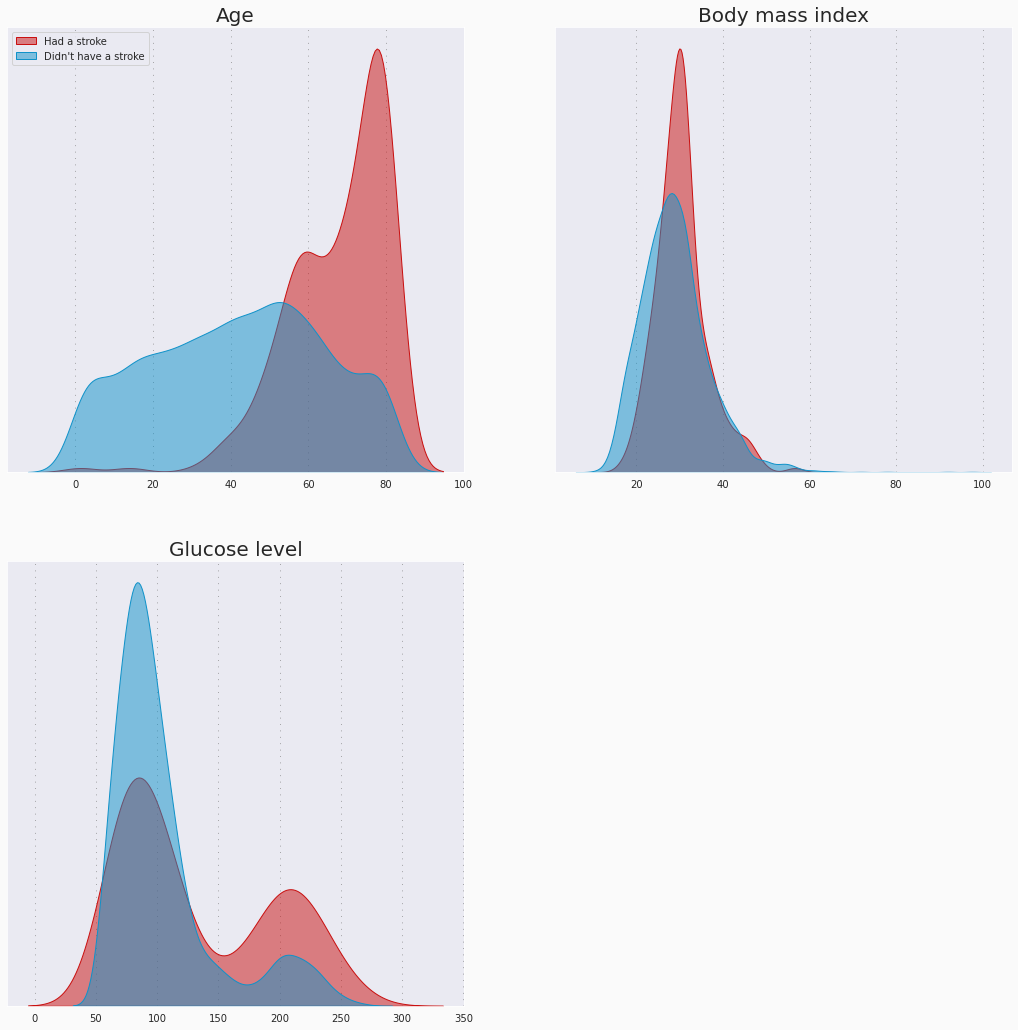

In [113]:
fig = plt.figure(figsize = (18, 18))
fig.patch.set_facecolor('#fafafa')

plt.subplot(221)
sns.set_style("dark")
plt.title('Age', size = 20)
sns.kdeplot(stroke.query('stroke == 1')['age'], color = '#c91010', shade = True, label = 'Had a stroke', alpha = 0.5)
sns.kdeplot(stroke.query('stroke == 0')['age'], color = '#1092c9', shade = True, label = "Didn't have a stroke", alpha = 0.5)
plt.grid(color = 'gray', linestyle = ':', axis = 'x', zorder = 0,  dashes = (1,7))
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.legend(loc = 'upper left')

plt.subplot(222)
plt.title('Body mass index', size = 20)
sns.kdeplot(stroke.query('stroke == 1')['bmi'], color = '#c91010', shade = True, label = 'Had a stroke', alpha = 0.5)
sns.kdeplot(stroke.query('stroke == 0')['bmi'], color = '#1092c9', shade = True, label = "Didn't have a stroke", alpha = 0.5)
plt.grid(color = 'gray', linestyle = ':', axis = 'x', zorder = 0,  dashes = (1,7))
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.legend('').set_visible(False)

plt.subplot(223)
plt.title('Glucose level', size = 20)
sns.kdeplot(stroke.query('stroke == 1')['avg_glucose_level'], color = '#c91010', shade = True, label = 'Had a stroke', alpha = 0.5)
sns.kdeplot(stroke.query('stroke == 0')['avg_glucose_level'], color = '#1092c9', shade = True, label = "Didn't have a stroke", alpha = 0.5)
plt.grid(color = 'gray', linestyle = ':', axis = 'x', zorder = 0,  dashes = (1,7))
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.legend('').set_visible(False)

plt.show()

**Affect of age group and heart diseases**

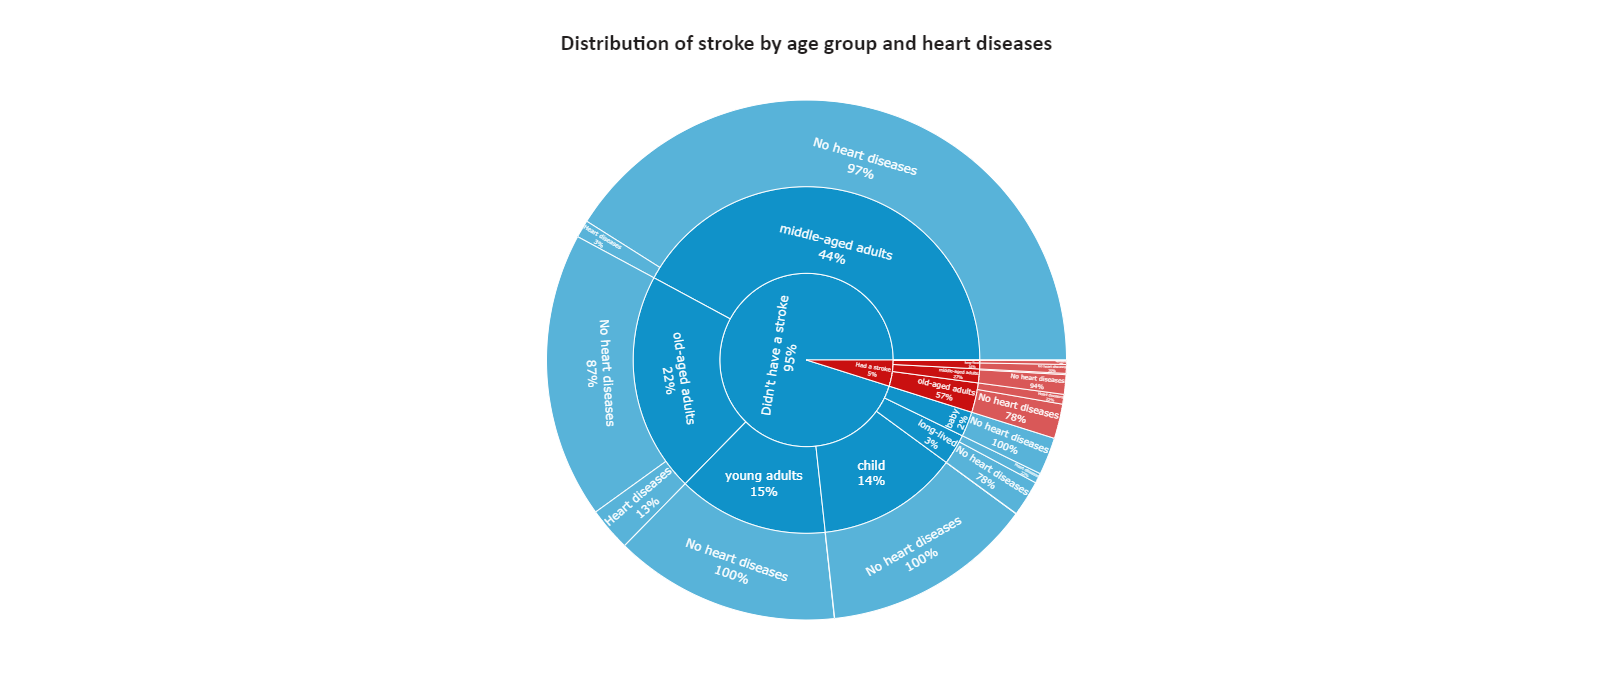

In [133]:
main = stroke.groupby(['age_group', 'heart_disease', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
ht = {0: 'No heart diseases', 1: 'Heart diseases'}
st = {0: "Didn't have a stroke", 1: "Had a stroke"}
main['heart_disease'] = main['heart_disease'].map(ht)
main['stroke'] = main['stroke'].map(st)

fig = px.sunburst(main, path = ['stroke', 'age_group', 'heart_disease'], values = 'count', color = 'stroke', title = 'Distribution of stroke by age group and heart diseases',
                 color_discrete_map = {"Didn't have a stroke": '#1092c9', "Had a stroke": '#c91010'},
                 width = 700, height = 700)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

# Conclusions of EDA

1. Based on the data, gender does not affect the probability of stroke, but in fact men have a higher risk of stroke, howewer, women have a higher mortality rate from stroke. This is a medical fact.
2. There is a large correlation between age and stroke risk. Almost all doctors know that stroke is most often an age problem. However, this can also happen with childs, in the available data in groups "baby" and "child", 2 people had a stroke.
3. The presence of hypertension or heart diseases have affect on stroke risk.
4. People who are married have a higher risk of stroke. I think it's a coincidence.
5. The author of the dataset did not specify what is meant "children" type of work, working with children in kindergartens and schools or caring for their children, but in any case children have a positive impact on the health of adults.
6. Living in a rural or urban areas does not affect the risk of stroke in any way.
7. Smoking also does not affect the risk of stroke. If draw conclusions only by the data, then yes, but if you have at least the slightest knowledge of medicine, you should know that smoking leads to problems with blood vessels, and this in turn can lead to heart diseases or hypertension, which is already a problem.
8. Obesity leads not only to problems with blood vessels and many others, but also to the risk of stroke.
9. Diabetes has an impact on the risk of stroke.

# Preprocessing

In [114]:
X = stroke.drop(['id', 'stroke'], axis = 1)
y = stroke['stroke']

num_cols = X.select_dtypes(include = ['int64', 'float64']).columns.to_list()
cat_cols = X.select_dtypes(include = ['object']).columns.to_list()

In [115]:
def label_encoder(df):
    for i in cat_cols:
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    return df

In [116]:
sc = StandardScaler()
X[num_cols] = sc.fit_transform(X[num_cols])

# Label encoding
X = label_encoder(X)

X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,age_group,bmi_group,glucose_group
0,1,1.051434,-0.328602,4.185032,1,2,1,2.706375,0.993769,1,4,1,0
1,0,0.786070,-0.328602,-0.238947,1,3,0,2.121559,0.163300,2,4,1,0
2,1,1.626390,-0.328602,4.185032,1,2,0,-0.005028,0.462923,2,2,1,2
3,0,0.255342,-0.328602,-0.238947,1,2,1,1.437358,0.708925,3,3,1,0
4,0,1.582163,3.043196,-0.238947,1,3,0,1.501184,-0.637610,2,4,0,0


# Modeling

**For modeling I try to use 6 models:**

1. SVC, 
2. KNN,
3. Logistic Regression,
4. Random Forest Classifier,
5. XGBClassifier,
6. LGBMClasifier.

But we have an imbalanced data. Standard ML methods, such as Decision Tree and Logistic Regression, tend to deviate from the majority class and tend to ignore the minority class. They tend to only predict the majority class, hence have a significant misclassification of the minority class as compared to the majority class.

In [117]:
stroke['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

So, we should to do SMOTE (Synthetic Minority Over-sampling Technique) - one of the most commonly used resampling techniques to solve the imbalance problem.

In [118]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

smote = SMOTE()

X_train_balanced, Y_train_balanced = smote.fit_resample(X_train, y_train)

In [119]:
results = pd.DataFrame(columns = ['SVC', 'KNN', 'LR', 'RF', 'XGB', 'LGBM'], index = range(4))

# SVC

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       967
           1       0.13      0.45      0.20        55

    accuracy                           0.81      1022
   macro avg       0.55      0.64      0.55      1022
weighted avg       0.92      0.81      0.85      1022

ROC AUC score: 0.779

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.94
precision: 0.84
recall: 0.92
f1: 0.88


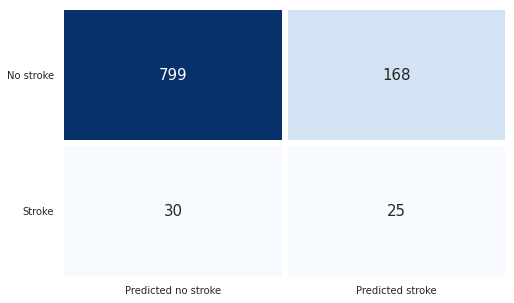

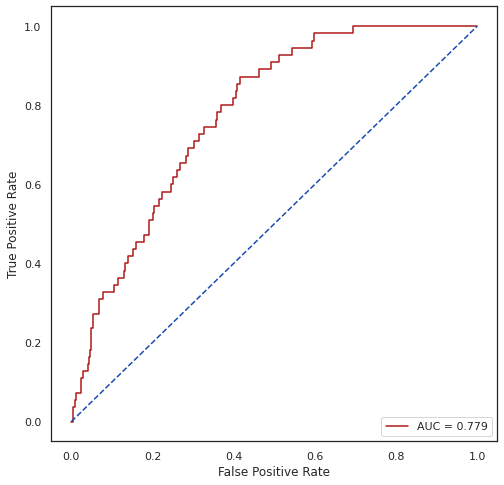

In [120]:
svc = SVC(random_state = 22, probability = True)
svc.fit(X_train_balanced, Y_train_balanced)
y_pred = svc.predict(X_test)
y_prob = svc.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 0] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 0] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 0] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 0] = round(roc_auc_score(y_test, y_prob), 3)
svc_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(svc, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(svc, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(svc, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(svc, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'f1').mean(), 2)}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(svc_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# KNN

              precision    recall  f1-score   support

           0       0.96      0.86      0.90       967
           1       0.12      0.36      0.19        55

    accuracy                           0.83      1022
   macro avg       0.54      0.61      0.55      1022
weighted avg       0.91      0.83      0.87      1022

ROC AUC score: 0.663

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.96
precision: 0.86
recall: 0.99
f1: 0.92


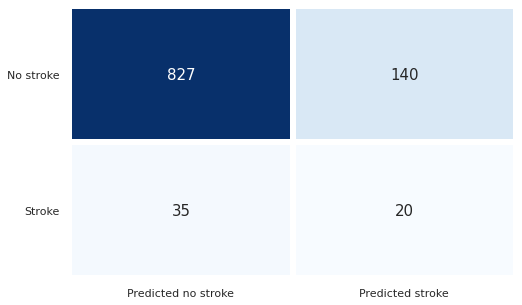

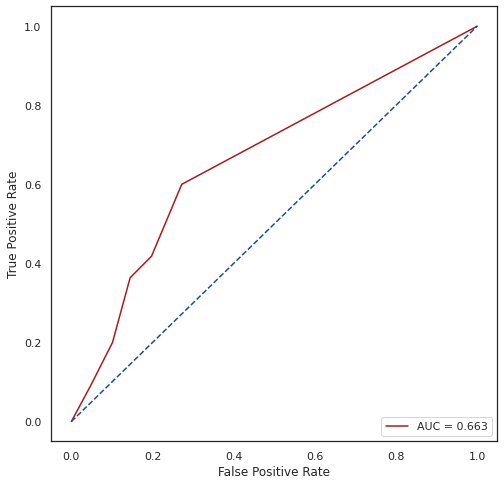

In [121]:
knn = KNeighborsClassifier()
knn.fit(X_train_balanced, Y_train_balanced)
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 1] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 1] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 1] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 1] = round(roc_auc_score(y_test, y_prob), 3)
knn_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(knn, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(knn, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(knn, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(knn, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'f1').mean(), 2)}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(knn_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       967
           1       0.15      0.64      0.24        55

    accuracy                           0.78      1022
   macro avg       0.56      0.71      0.56      1022
weighted avg       0.93      0.78      0.84      1022

ROC AUC score: 0.815

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.885
precision: 0.79
recall: 0.84
f1: 0.82


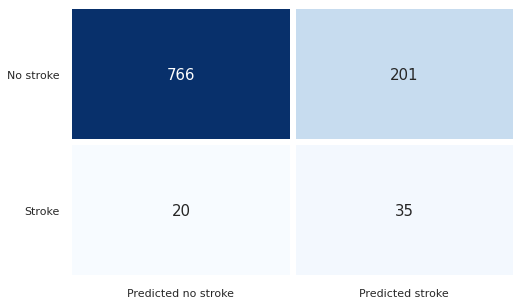

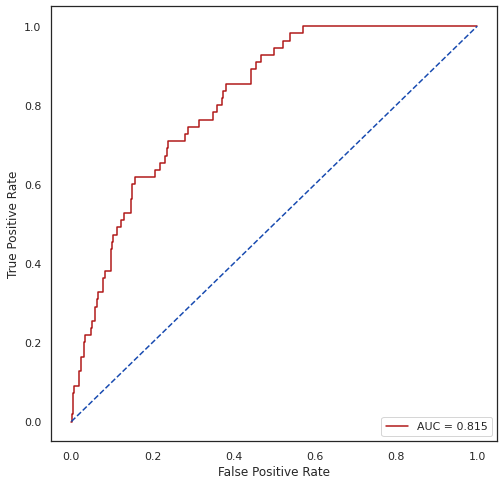

,feature,importance (abs coef)
1,age,2.173266
0,gender,0.818884
4,ever_married,0.635808
6,Residence_type,0.620801
12,glucose_group,0.592517
10,age_group,0.527716
9,smoking_status,0.240831
5,work_type,0.137904
11,bmi_group,0.089355
2,hypertension,0.081870


In [122]:
lg = LogisticRegression(random_state = 22)
lg.fit(X_train_balanced, Y_train_balanced)
y_pred = lg.predict(X_test)
y_prob = lg.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 2] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 2] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 2] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 2] = round(roc_auc_score(y_test, y_prob), 3)
lg_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(lg, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(lg, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(lg, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(lg, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'f1').mean(), 2)}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(lg_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp = pd.DataFrame(columns = ['feature', 'importance (abs coef)'], index = range(13))
for i in range(len(f_imp.index)):
    f_imp.iloc[i, 0] = X_train_balanced.columns.to_list()[i]
f_imp['importance (abs coef)'] = abs(lg.coef_)[0]
f_imp = f_imp.sort_values('importance (abs coef)', ascending = False)
f_imp[0:12].style.background_gradient(cmap = 'Blues')

# Random Forest Classifier

              precision    recall  f1-score   support

           0       0.98      0.76      0.86       967
           1       0.14      0.71      0.24        55

    accuracy                           0.76      1022
   macro avg       0.56      0.73      0.55      1022
weighted avg       0.93      0.76      0.82      1022

ROC AUC score: 0.829

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.921
precision: 0.78
recall: 0.9
f1: 0.84


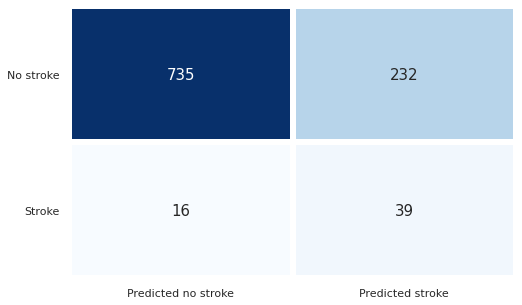

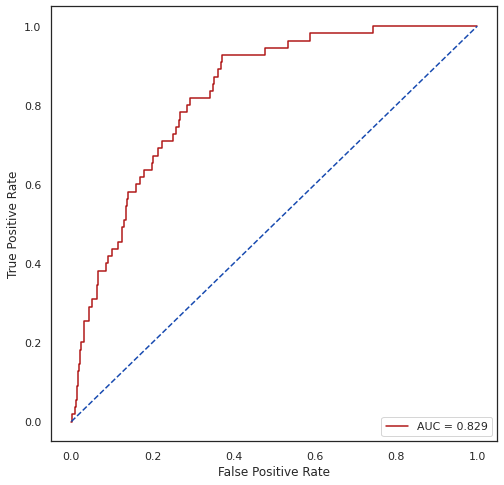

,feature,importance
1,age,0.576452
10,age_group,0.092109
7,avg_glucose_level,0.068046
5,work_type,0.060914
8,bmi,0.049068
12,glucose_group,0.041001
2,hypertension,0.025209
11,bmi_group,0.020553
3,heart_disease,0.017757
0,gender,0.015414


In [123]:
rf = RandomForestClassifier(random_state = 22, max_depth = 5)
rf.fit(X_train_balanced, Y_train_balanced)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 3] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 3] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 3] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 3] = round(roc_auc_score(y_test, y_prob), 3)
rf_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(rf, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(rf, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(rf, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(rf, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'f1').mean(), 2)}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(rf_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp2 = pd.DataFrame(columns = ['feature', 'importance'], index = range(13))
for i in range(len(f_imp2.index)):
    f_imp2.iloc[i, 0] = X_train_balanced.columns.to_list()[i]
f_imp2['importance'] = rf.feature_importances_
f_imp2 = f_imp2.sort_values('importance', ascending = False)
f_imp2[0:12].style.background_gradient(cmap = 'Blues')

# XGBClassifier

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       967
           1       0.21      0.20      0.20        55

    accuracy                           0.92      1022
   macro avg       0.58      0.58      0.58      1022
weighted avg       0.91      0.92      0.92      1022

ROC AUC score: 0.802

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.99
precision: 0.95
recall: 0.95
f1: 0.95


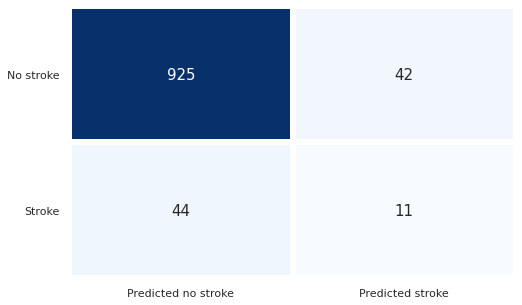

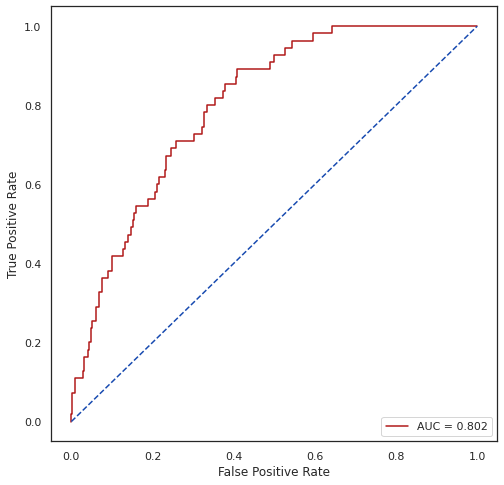

,feature,importance
1,age,0.174352
5,work_type,0.103640
12,glucose_group,0.102051
11,bmi_group,0.098565
0,gender,0.092344
10,age_group,0.089753
4,ever_married,0.086815
6,Residence_type,0.047579
8,bmi,0.046476
3,heart_disease,0.045601


In [124]:
xgb = XGBClassifier(random_state = 22, max_depth = 5, objective = 'binary:logistic', eval_metric = 'logloss')
xgb.fit(X_train_balanced, Y_train_balanced)
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 4] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 4] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 4] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 4] = round(roc_auc_score(y_test, y_prob), 3)
xgb_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(xgb, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(xgb, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(xgb, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(xgb, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'f1').mean(), 2)}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(xgb_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp3 = pd.DataFrame(columns = ['feature', 'importance'], index = range(13))
for i in range(len(f_imp3.index)):
    f_imp3.iloc[i, 0] = X_train_balanced.columns.to_list()[i]
f_imp3['importance'] = xgb.feature_importances_
f_imp3 = f_imp3.sort_values('importance', ascending = False)
f_imp3[0:12].style.background_gradient(cmap = 'Blues')

# LGBM

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       967
           1       0.18      0.36      0.24        55

    accuracy                           0.87      1022
   macro avg       0.57      0.63      0.58      1022
weighted avg       0.92      0.87      0.89      1022

ROC AUC score: 0.8

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.98
precision: 0.9
recall: 0.95
f1: 0.92


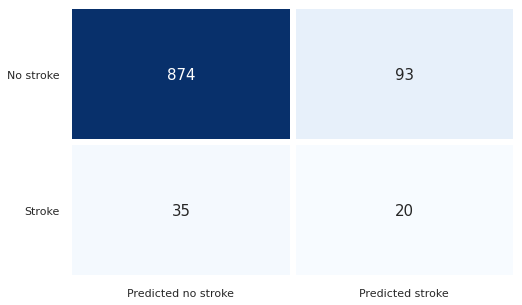

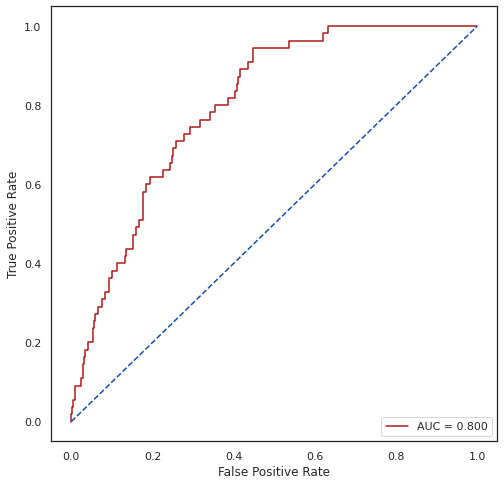

,feature,importance
1,age,680
7,avg_glucose_level,479
8,bmi,416
5,work_type,160
9,smoking_status,153
11,bmi_group,144
10,age_group,123
0,gender,84
6,Residence_type,61
4,ever_married,50


In [125]:
lgbm = LGBMClassifier(random_state = 22, max_depth = 5, num_leaves = 50)
lgbm.fit(X_train_balanced, Y_train_balanced)
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 5] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 5] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 5] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 5] = round(roc_auc_score(y_test, y_prob), 3)
lgbm_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(lgbm, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(lgbm, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(lgbm, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(lgbm, X_train_balanced, Y_train_balanced, cv = 5, scoring = 'f1').mean(), 2)}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(lgbm_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp4 = pd.DataFrame(columns = ['feature', 'importance'], index = range(13))
for i in range(len(f_imp4.index)):
    f_imp4.iloc[i, 0] = X_train_balanced.columns.to_list()[i]
f_imp4['importance'] = lgbm.feature_importances_
f_imp4 = f_imp4.sort_values('importance', ascending = False)
f_imp4[0:12].style.background_gradient(cmap = 'Blues')

# Conclusion

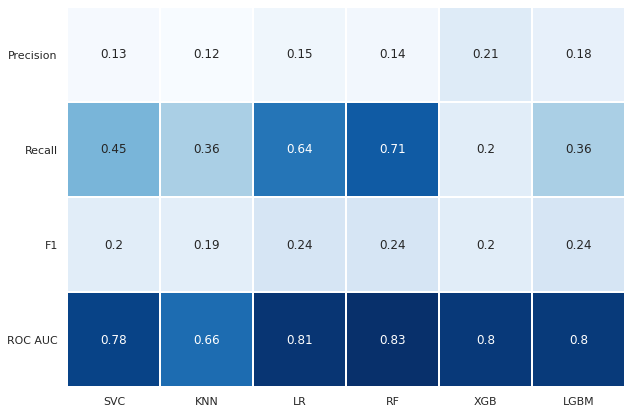

In [126]:
plt.figure(figsize = (10, 7))
sns.heatmap(results[results.columns.to_list()].astype(float), cmap = 'Blues', annot = True, linewidths = 1, cbar = False, annot_kws = {'fontsize': 12},
           yticklabels = ['Precision', 'Recall', 'F1', 'ROC AUC'])
sns.set(font_scale = 1.5)
plt.yticks(rotation = 0)
plt.show()

**Short summary - if it is important for us to identify all people who may have a stroke (good recall), then it is best to cope with this task with Random Forest, but if we are interested in the precision of predictions, then we should choose XGB (although the difference in precision is negligible). We can also change the standard threshold of 0.5 for assignment to one of the classes to increase one of the metrics.**

**Predicting a stroke based on basic data seems like something fantastic, but the fact that Random Forest without tuning and only with 5110 observations can find ~70% of those who have had a stroke is an excellent result!**

**But, in my opinion, the number of people for this medical analysis is very small, it would be more interesting and practical to make an analysis on a sample of 100 thousand or more people.**